🧠 Pourquoi aller au-delà du content-based ?<br>
Les limites de l’approche content-based sont :<br>
- Dépendance aux métadonnées : Les recommandations sont limitées à la qualité et la richesse des informations descriptives sur les articles (embeddings, tags, texte, etc.).
- Filtre de similarité trop restreint : On ne recommande que ce qui ressemble à ce que l'utilisateur a déjà aimé. Cela limite la découverte de contenus différents mais pertinents.
- Cold-start utilisateurs : Pour un nouvel utilisateur sans historique, l’algorithme ne peut rien proposer (sauf à utiliser un profil par défaut).
- Redondance/absence de diversité : Tendance à recommander toujours les mêmes types d’articles, d’où un risque de lassitude.

🔄 Le collaborative filtering apporte :<br>
1. Apprentissage des préférences collectives<br>
Le collaborative filtering se base sur les comportements d’utilisateurs similaires, pas sur les caractéristiques des articles.<br>
Cela permet de découvrir des articles qu’un utilisateur n’aurait jamais trouvé seul, mais que des profils proches ont appréciés.

2. Exploration plus large du catalogue<br>
Permet de recommander des contenus différents de ceux consultés précédemment, car l’algorithme exploite des corrélations implicites entre utilisateurs et articles.

3. Indépendance du contenu<br>
Aucune connaissance du contenu n’est requise (pas besoin d’embeddings ou de textes).Cela le rend utile même quand les métadonnées sont absentes, incomplètes ou peu informatives.<br>

| Critère                    | Content-Based            | Collaborative Filtering                  |
| -------------------------- | ------------------------ | ---------------------------------------- |
| Basé sur                   | Similarité de contenu    | Similarité de comportements utilisateurs |
| Cold-start articles        | Géré facilement          | Problématique                            |
| Cold-start utilisateurs    | Problématique            | Problématique                            |
| Capacité à explorer        | Faible (proche du connu) | Bonne (serendipité accrue)               |
| Dépendance aux métadonnées | Forte                    | Aucune                                   |


# Filtrage collaboratif avec Surprise (Simple Python Recommendation System Engine)

## Données

## Chargement du dataframe global

In [1]:
import pandas as pd

df = pd.read_parquet("./data/df_final.parquet")
print("✅ Dataset rechargé avec succès.")

✅ Dataset rechargé avec succès.


In [2]:
df.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321484,0.910162,-0.413011,0.680835,-0.418409,-0.526443,0.305625,-0.307805,-0.606366,-0.650556
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,-1.001013,0.797471,-0.492230,-0.305857,-1.307835,0.354010,0.696917,-0.486316,0.017210,-1.563045
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,...,-0.269690,0.873445,0.194144,0.056367,-0.431036,-0.020383,-0.376942,0.814494,0.709722,-1.030146
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,...,0.144034,-2.457183,-1.500929,-1.807169,-0.208940,-0.671638,-0.407914,2.561696,-1.379031,-1.877568
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,...,-1.163678,-0.230112,-2.132536,-0.729996,0.581913,-0.559910,-0.354824,-0.914158,-0.064399,-0.354175


## Liste des articles

In [3]:
df_articles = pd.read_csv("./data/articles_with_popularity.csv", encoding='utf-8')
df_articles

,article_id,category_id,created_at_ts,publisher_id,words_count,cluster,publish_time_dt,nb_clics,popularite_tag,popularity_norm
0,0,0,1513144419000,0,168,16,2017-12-13 05:53:39,0,jamais_cliqué,0.000000
1,1,1,1405341936000,0,189,11,2014-07-14 12:45:36,0,jamais_cliqué,0.000000
2,2,1,1408667706000,0,250,3,2014-08-22 00:35:06,0,jamais_cliqué,0.000000
3,3,1,1408468313000,0,230,3,2014-08-19 17:11:53,1,banal,0.000027
4,4,1,1407071171000,0,162,3,2014-08-03 13:06:11,0,jamais_cliqué,0.000000
...,...,...,...,...,...,...,...,...,...,...
364042,364042,460,1434034118000,0,144,2,2015-06-11 14:48:38,0,jamais_cliqué,0.000000
364043,364043,460,1434148472000,0,463,7,2015-06-12 22:34:32,8,banal,0.000215
364044,364044,460,1457974279000,0,177,6,2016-03-14 16:51:19,0,jamais_cliqué,0.000000
364045,364045,460,1515964737000,0,126,1,2018-01-14 21:18:57,0,jamais_cliqué,0.000000


## Chargement des embeddings réduits

In [4]:
import pandas as pd

embeddings_df = pd.read_parquet('./data/articles_embeddings_pca.parquet')
print(embeddings_df.shape)

(364047, 41)


In [5]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
article_id,,,,,,,,,,,,,,,,,,,,,
0,-1.854453,-5.592402,1.708724,-3.835164,1.415795,0.252210,0.426074,0.545480,-0.807394,1.520171,...,0.387738,-0.088799,0.990514,1.060148,-0.218378,-1.099852,-1.175524,1.370632,-0.264816,0.010117
1,-5.361997,4.122991,-2.357516,-3.428017,-0.431079,3.722260,2.389835,-1.267244,1.944162,2.980629,...,0.025565,-0.721510,0.649929,-0.405225,-0.090690,-3.094968,0.075186,0.245235,-1.250343,0.294538
2,-3.600085,-0.132112,-6.027451,0.985617,0.211965,4.591712,-1.815688,-2.170389,-2.783090,2.804910,...,0.565647,-1.862223,-0.336458,0.072410,0.241466,-0.877634,0.154883,1.133963,0.946740,-1.811314
3,-1.158963,7.293352,-5.916713,-1.370524,2.172241,-1.682487,1.070822,-2.160001,1.947324,4.069597,...,0.074049,-0.612824,-1.511408,1.071736,1.991838,-2.076190,-1.690459,-1.122692,0.714619,-1.576244
4,-1.142884,2.569328,-2.891860,-0.273997,2.913007,5.608970,0.308953,0.310888,-1.054171,2.158180,...,-1.527867,-0.155615,-0.163345,0.037253,1.173636,-4.232923,-1.287476,1.053438,-0.486085,-0.144550


In [6]:
# conversion des embeddings en tableau NumPy (évite de calculer la matrice de similarité complète)
import numpy as np
article_ids = embeddings_df.index.to_numpy()
article_embeddings = embeddings_df.to_numpy()

# dictionnaire article_id -> vecteur
embedding_dict = dict(zip(article_ids, article_embeddings))

## Echantilonnage

In [7]:
def create_subset(
    df,
    n_users=None,
    n_articles=None,
    n_interactions=None,
    seed=42,
    filter_sparse=True,
    verbose=True,
    user_col='user_id',
    item_col=None,
    rating_col='rating'
):
    """
    Crée un sous-échantillon du DataFrame d'interactions avec un filtrage
    optionnel par nombre d'utilisateurs, d'articles, de lignes, et supprime
    les utilisateurs/articles sans interaction positive si filter_sparse=True.

    Args:
        df (DataFrame): DataFrame principal contenant les interactions
        n_users (int, optional): nombre d'utilisateurs à conserver
        n_articles (int, optional): nombre d'articles les plus populaires à conserver
        n_interactions (int, optional): nombre total de lignes à conserver (après filtrage)
        seed (int): graine pour échantillonnage aléatoire
        filter_sparse (bool): si True, supprime les users/items sans interactions positives
        verbose (bool): si True, affiche des informations sur la réduction
        user_col (str): nom de la colonne utilisateur
        item_col (str, optional): nom de la colonne article (détecté automatiquement sinon)
        rating_col (str): nom de la colonne de rating (utilisé pour filtrer les interactions positives)

    Returns:
        df_subset (DataFrame): le DataFrame filtré
    """
    df_subset = df.copy()

    # Détection automatique du nom de la colonne article
    if item_col is None:
        if 'click_article_id' in df.columns:
            item_col = 'click_article_id'
        elif 'article_id' in df.columns:
            item_col = 'article_id'
        else:
            raise ValueError("Aucune colonne article trouvée (attendue : 'click_article_id' ou 'article_id')")

    # Vérifications de base
    for col in [user_col, item_col]:
        assert col in df_subset.columns, f"La colonne '{col}' est manquante dans le DataFrame."

    if n_users is not None:
        selected_users = df_subset[user_col].drop_duplicates().sample(n_users, random_state=seed)
        df_subset = df_subset[df_subset[user_col].isin(selected_users)]

    if n_articles is not None:
        top_articles = df_subset[item_col].value_counts().head(n_articles).index
        df_subset = df_subset[df_subset[item_col].isin(top_articles)]

    if n_interactions is not None and len(df_subset) > n_interactions:
        df_subset = df_subset.sample(n_interactions, random_state=seed)

    # 🧽 Nettoyage des utilisateurs/articles sans rating positif
    if filter_sparse and rating_col in df_subset.columns:
        pos = df_subset[df_subset[rating_col] > 0]
        valid_users = pos[user_col].unique()
        valid_items = pos[item_col].unique()
        df_subset = df_subset[
            df_subset[user_col].isin(valid_users) &
            df_subset[item_col].isin(valid_items)
        ]

    if verbose:
        print(f"[INFO] Shape après filtrage : {df_subset.shape}")
        n_u = df_subset[user_col].nunique()
        n_i = df_subset[item_col].nunique()
        print(f"[INFO] Utilisateurs: {n_u} | Articles: {n_i} | Interactions: {len(df_subset)}")

    return df_subset


## Meilleure approche "data"

### Préparation des données pour Surprise

In [8]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from collections import defaultdict
import random
from tqdm.notebook import tqdm
from sklearn.neighbors import NearestNeighbors

### === 1. Préparation des données === ###

def build_binary_df(df):
    ''' Le rating est 1 pour chaque paire (user,article), pas d'interaction négative
        ⚠️ Limites: Le modèle n'apprendra pas ce que l'utilisateur n'aime pas
        et risque de surinterpréter les clics positifs comme préférentiels
    '''
    df_binary = df[['user_id', 'click_article_id']].drop_duplicates() # on ne garde qu'une seul interaction user, article
    df_binary['rating'] = 1
    df_binary.columns = ['user_id', 'article_id', 'rating']
    return df_binary


def build_binary_negative_sampling_full(df, min_article_clicks=1):
    ''' En plus du ratin 1 on ajoute un rating négatif (rating=0) pour les articles non cliqués
        ⚠️ En plus de l'explosion des données cette construction est très sévère
        La distribution sera très déséquilibrée (se rapproche d'une classification implicite)
    '''
    # Articles populaires cliqués au moins X fois
    clicked_counts = df['click_article_id'].value_counts()
    clicked_articles = set(clicked_counts[clicked_counts >= min_article_clicks].index)

    df_pos = df[['user_id', 'click_article_id']].drop_duplicates()
    df_pos['rating'] = 1
    df_pos.columns = ['user_id', 'article_id', 'rating']

    user_clicks = df_pos.groupby('user_id')['article_id'].apply(set).to_dict()

    negatives = []

    for user, clicked in user_clicks.items():
        negatives_for_user = clicked_articles - clicked
        for neg_item in negatives_for_user:
            negatives.append((user, neg_item, 0))

    df_neg = pd.DataFrame(negatives, columns=['user_id', 'article_id', 'rating'])
    df_final = pd.concat([df_pos, df_neg], ignore_index=True)
    return df_final


def build_weighted_df(df):
    ''' On prend en compte les clics multiples d'un utilisation sur un même article
        Ils sont agrégés pour produire un score (rating ∈ (0,1])
        On ne garde que les interactions positives
        L'intérêt de l'utilisateur est nuancé, modélisation continue
    '''   
    df_weighted = (
        df.groupby(['user_id', 'click_article_id'])
          .size()
          .reset_index(name='click_count')
    )
    max_clicks = df_weighted['click_count'].max()
    df_weighted['rating'] = df_weighted['click_count'] / max_clicks
    df_weighted.columns = ['user_id', 'article_id', 'click_count', 'rating']
    return df_weighted[['user_id', 'article_id', 'rating']]


def build_weighted_negative_sampling_full(df, min_article_clicks=1):
    ''' Combinaison de l'approche pondérée par le nombre de clicks
        avec les interactions négatives
    '''
    # Articles populaires
    clicked_counts = df['click_article_id'].value_counts()
    clicked_articles = set(clicked_counts[clicked_counts >= min_article_clicks].index)

    df_pos = (
        df.groupby(['user_id', 'click_article_id'])
          .size()
          .reset_index(name='click_count')
    )
    max_clicks = df_pos['click_count'].max()
    df_pos['rating'] = df_pos['click_count'] / max_clicks
    df_pos.columns = ['user_id', 'article_id', 'click_count', 'rating']
    df_pos = df_pos[['user_id', 'article_id', 'rating']]

    user_clicks = df_pos.groupby('user_id')['article_id'].apply(set).to_dict()

    negatives = []

    for user, clicked in user_clicks.items():
        negatives_for_user = clicked_articles - clicked
        for neg_item in negatives_for_user:
            negatives.append((user, neg_item, 0))

    df_neg = pd.DataFrame(negatives, columns=['user_id', 'article_id', 'rating'])
    df_final = pd.concat([df_pos, df_neg], ignore_index=True)
    return df_final


def build_negative_sampling_df(df_pos, embeddings_df, k=10):
    ''' Le sampling négatif est guidé par la proximité sémantique des articles
        Les négatifs sont plus crédibles, mais nécessite les embeddings et
        demande des ressources pour NearestNeighbors et kNN
    '''
    from sklearn.neighbors import NearestNeighbors
    from tqdm.notebook import tqdm

    df_pos_unique = df_pos[['user_id', 'click_article_id']].drop_duplicates()

    model_knn = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='cosine')
    model_knn.fit(embeddings_df.values)
    article_ids = embeddings_df.index.values
    article_index = {aid: idx for idx, aid in enumerate(article_ids)}

    negatives = []

    user_clicks = df_pos_unique.groupby('user_id')['click_article_id'].apply(set).to_dict()

    print("🔍 Génération du sampling négatif avec embeddings (par utilisateur)...")
    for user, clicked_set in tqdm(user_clicks.items()):
        for pos_item in clicked_set:
            if pos_item not in article_index:
                continue
            idx = article_index[pos_item]
            distances, indices = model_knn.kneighbors([embeddings_df.loc[pos_item].values], n_neighbors=k+1)
            similar_items = [article_ids[i] for i in indices[0][1:] if article_ids[i] not in clicked_set]
            for neg_item in similar_items:
                negatives.append((user, neg_item, 0))

    df_neg = pd.DataFrame(negatives, columns=['user_id', 'article_id', 'rating'])
    df_pos_renamed = df_pos_unique.copy()
    df_pos_renamed.columns = ['user_id', 'article_id']
    df_pos_renamed['rating'] = 1
    df_final = pd.concat([df_pos_renamed, df_neg], ignore_index=True)
    return df_final

### Fonctions d'entrainement de recommandation et mesure de la performance

In [9]:
from surprise import accuracy
### === 2. Pipeline de modélisation et de recommandation === ###

def train_and_evaluate(df_ratings, n_top=5):
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(df_ratings[['user_id', 'article_id', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.2)
    algo = SVD()  # choix de l'algorithme
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Métriques de prédiction
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)

    # Métriques top-N
    top_n = get_top_n(predictions, n=n_top)
    topn_metrics = eval_top_n(top_n, testset, k=n_top)

    # Renommer les clés pour correspondre au CSV
    return {
        "RMSE": rmse,
        "MAE": mae,
        "Hit@5": topn_metrics["HitRate@5"],
        "MAP@5": topn_metrics["MAP@5"],
        "NDCG@5": topn_metrics["NDCG@5"],
        "Precision@5": topn_metrics["Precision@5"],
        "Recall@5": topn_metrics["Recall@5"]
    }

    
def get_top_n(predictions, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def eval_top_n(top_n, testset, k=5):
    relevance = defaultdict(set)
    for uid, iid, true_r in testset:
        if true_r > 0:
            relevance[uid].add(iid)

    hits, total = 0, 0
    ap_sum, ndcg_sum, precision_sum, recall_sum = 0, 0, 0, 0

    for uid, pred_items in top_n.items():
        pred_list = [iid for iid, _ in pred_items]
        true_set = relevance.get(uid, set())
        rel_list = [1 if iid in true_set else 0 for iid in pred_list]

        # HitRate@k
        if any(rel_list):
            hits += 1

        # MAP@k
        if true_set:
            num_hits = 0
            ap = 0
            for i, rel in enumerate(rel_list):
                if rel:
                    num_hits += 1
                    ap += num_hits / (i + 1)
            ap_sum += ap / min(len(true_set), k)

        # NDCG@k
        dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(rel_list))
        ideal_dcg = sum(1 / np.log2(i + 2) for i in range(min(len(true_set), k)))
        ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
        ndcg_sum += ndcg

        # Precision@k
        precision = sum(rel_list) / k
        precision_sum += precision

        # Recall@k
        if true_set:
            recall = sum(rel_list) / len(true_set)
            recall_sum += recall

        total += 1

    return {
        "HitRate@5": hits / total,
        "MAP@5": ap_sum / total,
        "NDCG@5": ndcg_sum / total,
        "Precision@5": precision_sum / total,
        "Recall@5": recall_sum / total
    }


### Expérimentation des différentes approches

In [20]:
# Modification du fichier de résultats
import pandas as pd
import numpy as np

# Chargement du fichier existant
chemin_csv = "./results/eval_results.csv"
df = pd.read_csv(chemin_csv)

# Colonnes à ajouter si absentes
colonnes_a_ajouter = ["RMSE", "MAE", "n_articles", "n_interactions"]
for col in colonnes_a_ajouter:
    if col not in df.columns:
        df[col] = np.nan

# Réorganisation dans l’ordre souhaité
colonnes_ordre = [
    "modèle", "approche", "n_users", "n_articles", "n_interactions",
    "RMSE", "MAE", "Hit@5", "MAP@5", "NDCG@5", "Precision@5", "Recall@5"
]
df = df[[col for col in colonnes_ordre if col in df.columns]]  # sécurité

# Sauvegarde
df.to_csv(chemin_csv, index=False)


In [10]:
df_small = create_subset(df, n_users=1000, n_articles=3000, n_interactions=100_000)
df_negatif_embedding = build_negative_sampling_df(df_small, embeddings_df, k=10)
df_negatif_embedding = create_subset(df_negatif_embedding, filter_sparse=True)

[INFO] Shape après filtrage : (8403, 66)
[INFO] Utilisateurs: 1000 | Articles: 2277 | Interactions: 8403
🔍 Génération du sampling négatif avec embeddings (par utilisateur)...


  0%|          | 0/1000 [00:00<?, ?it/s]

[INFO] Shape après filtrage : (13033, 3)
[INFO] Utilisateurs: 1000 | Articles: 2277 | Interactions: 13033


In [21]:
import matplotlib.pyplot as plt

def run_comparison(df, embeddings_df=None, df_negatif_precomputed=None, chemin_resultats="./results/eval_results.csv"):
    import os

    results = {}

    # Infos globales pour le logging
    n_users = df['user_id'].nunique()
    n_articles = df['click_article_id'].nunique()
    n_interactions = len(df)

    essais = [
        ("score binaire", build_binary_df(df)),
        ("pseudo-rating pondéré", build_weighted_df(df)),
        ("binaire + full négatifs", build_binary_negative_sampling_full(df)),
        ("pondéré + full négatifs", build_weighted_negative_sampling_full(df))
    ]

    print("▶ Approche 1 : score binaire")
    print("▶ Approche 2 : pseudo-rating pondéré")
    print("▶ Approche 3 : sampling négatif avec embeddings")
    print("▶ Approche 4 : binaire + full négatifs")
    print("▶ Approche 5 : pondéré + full négatifs")

    for nom_essai, df_prepared in essais:
        print(f"\n▶ {nom_essai}")
        result = train_and_evaluate(df_prepared)
        results[nom_essai] = result

        # Ajout des métadonnées
        result["modèle"] = nom_essai
        result["approche"] = "Surprise (Collaborative Filtering)"
        result["n_users"] = n_users
        result["n_articles"] = n_articles
        result["n_interactions"] = n_interactions

        # Enregistrement dans le CSV
        colonnes_ordre = [
            "modèle", "approche", "n_users", "n_articles", "n_interactions",
            "RMSE", "MAE", "Hit@5", "MAP@5", "NDCG@5", "Precision@5", "Recall@5"
        ]
        os.makedirs(os.path.dirname(chemin_resultats), exist_ok=True)
        if os.path.exists(chemin_resultats):
            df_csv = pd.read_csv(chemin_resultats)
            df_csv = pd.concat([df_csv, pd.DataFrame([result])], ignore_index=True)
        else:
            df_csv = pd.DataFrame([result])
        df_csv = df_csv[colonnes_ordre]
        df_csv.to_csv(chemin_resultats, index=False)

    # Approche 3 (embeddings négatifs) à part car embeddings nécessaires
    print("\n▶ sampling négatif avec embeddings")
    if df_negatif_precomputed is not None:
        df_neg = df_negatif_precomputed
    else:
        df_neg = build_negative_sampling_df(df, embeddings_df, k=10)

    result = train_and_evaluate(df_neg)
    results["sampling négatif avec embeddings"] = result

    # Ajout et enregistrement
    result["modèle"] = "sampling négatif avec embeddings"
    result["approche"] = "Surprise (Collaborative Filtering)"
    result["n_users"] = n_users
    result["n_articles"] = n_articles
    result["n_interactions"] = n_interactions

    df_csv = pd.read_csv(chemin_resultats)
    df_csv = pd.concat([df_csv, pd.DataFrame([result])], ignore_index=True)
    df_csv = df_csv[colonnes_ordre]
    df_csv.to_csv(chemin_resultats, index=False)

    # Résumé affiché
    df_results = pd.DataFrame(results).T
    print("\n🎯 Résumé des performances (k=5) :")
    print(df_results)

    # Graphique
    topn_metrics = ["Hit@5", "MAP@5", "NDCG@5", "Precision@5", "Recall@5"]
    error_metrics = ["RMSE", "MAE"]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    df_results[topn_metrics].plot(kind='bar', ax=ax1, position=0, width=0.35, colormap='tab10')
    ax1.set_ylabel("Top-N Metrics")
    ax1.set_ylim(0, 1.05)
    ax1.set_xlabel("Approche")
    ax1.set_xticklabels(df_results.index, rotation=0)
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    df_results[error_metrics].plot(kind='bar', ax=ax2, position=1, width=0.35, color=["gray", "black"])
    ax2.set_ylabel("Erreur (RMSE / MAE)")
    ax2.legend(loc='upper right')

    ax1.set_xlim(-0.5, len(df_results) - 0.25)
    plt.title("Comparaison des approches - Surprise (k=5)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return df_results

▶ Approche 1 : score binaire
▶ Approche 2 : pseudo-rating pondéré
▶ Approche 3 : sampling négatif avec embeddings
▶ Approche 4 : binaire + full négatifs
▶ Approche 5 : pondéré + full négatifs

▶ score binaire

▶ pseudo-rating pondéré

▶ binaire + full négatifs

▶ pondéré + full négatifs

▶ sampling négatif avec embeddings

🎯 Résumé des performances (k=5) :
                                      RMSE       MAE     Hit@5     MAP@5  \
score binaire                     0.055792  0.029186       1.0       1.0   
pseudo-rating pondéré             0.087802  0.063321       1.0       1.0   
binaire + full négatifs           0.061198   0.00822     0.218  0.067101   
pondéré + full négatifs           0.020156  0.002705     0.205  0.063637   
sampling négatif avec embeddings  0.346844  0.268701  0.843324  0.814741   

                                    NDCG@5 Precision@5  Recall@5  \
score binaire                          1.0    0.435747  0.963611   
pseudo-rating pondéré                  1.0    0.

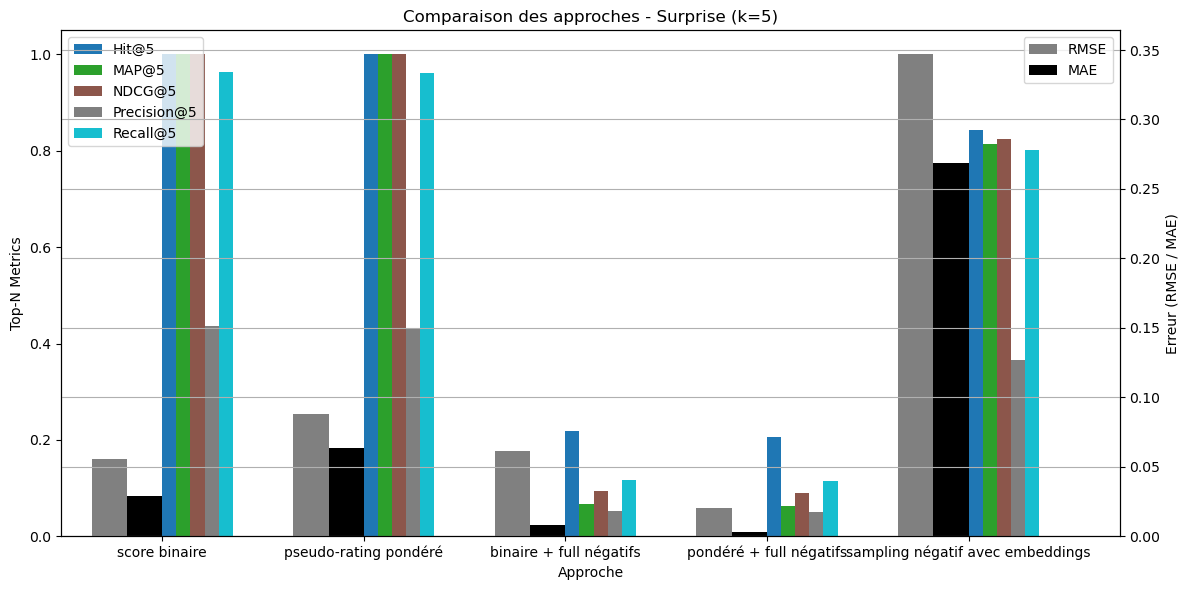

In [22]:
results_df = run_comparison(df_small, df_negatif_precomputed=df_negatif_embedding)

⚠️ Analyse:<br>
Les scores parfaits (1.0) sur binaire et pondéré sont presque sûrement dus à:<br>
- le surapprentissage causé par l’absence de négatifs.
- Des testsets qui contiennent uniquement des positifs, donc tous les articles sont "bons" → le modèle n’est pas challengé.<br>
    👉 Ces résultats biaisés doivent être interprétés avec prudence.

Impact du sampling négatif : On voit bien que l’ajout de négatifs diminue drastiquement les scores top-N, mais cela rend les résultats plus réalistes.
    👉 Un élément essentiel pour l'approche filtrage collaboratif.
 
🔎 Les métriques classiques comme RMSE/MAE ne suffisent pas à évaluer un système de recommandation implicite.

## Tests de différents algorithmes

In [11]:
from surprise import Dataset, Reader, SVD, SVDpp, NMF, KNNBasic, BaselineOnly, CoClustering
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict
import pandas as pd
import numpy as np
from surprise import AlgoBase
import random


### Fonction de comparaison des algorithmes

In [12]:
from surprise import AlgoBase
import random

class RandomPredictor(AlgoBase):
    def __init__(self, seed=42):
        super().__init__()
        self.seed = seed
        self.random_state = random.Random(seed)

    def fit(self, trainset):
        super().fit(trainset)
        return self

    def estimate(self, u, i):
        return self.random_state.uniform(0, 1)


<i> Pour knn il n'est pas possible de calculer la matrice de similarité complète, on teste item-item et user-user sur des échantillons d'où l'option sim 

In [13]:
def compare_algos(df_ratings, k=5, chemin_resultats="./results/eval_results.csv"):
    import os

    # Statistiques du dataset
    n_users = df_ratings['user_id'].nunique()
    n_articles = df_ratings['article_id'].nunique()
    n_interactions = len(df_ratings)

    # Dataset Surprise
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(df_ratings[['user_id', 'article_id', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

    algos = {
        "SVD": SVD(),
        "SVDpp": SVDpp(),
        "NMF": NMF(),
        "KNN_user": KNNBasic(
            k=40,
            sim_options={'name': 'msd', 'user_based': True}
        ),
        "KNN_item": KNNBasic(
            k=40,
            sim_options={'name': 'msd', 'user_based': False}
        ),
        "BaselineOnly": BaselineOnly(),
        "CoClustering": CoClustering(),
        "Random": RandomPredictor()
    }

    results = []
    for name, algo in algos.items():
        print(f"\n▶ Entraînement de {name}...")
        algo.fit(trainset)
        predictions = algo.test(testset)

        # Métriques
        rmse = accuracy.rmse(predictions, verbose=False)
        mae = accuracy.mae(predictions, verbose=False)
        top_n = get_top_n(predictions, n=k)
        metrics = eval_top_n(top_n, testset, k=k)

        # Résultat enrichi
        result = {
            "modèle": name,
            "approche": "Surprise (Collaborative Filtering)",
            "n_users": n_users,
            "n_articles": n_articles,
            "n_interactions": n_interactions,
            "RMSE": rmse,
            "MAE": mae,
            "Hit@5": metrics["HitRate@5"],
            "MAP@5": metrics["MAP@5"],
            "NDCG@5": metrics["NDCG@5"],
            "Precision@5": metrics["Precision@5"],
            "Recall@5": metrics["Recall@5"]
        }

        results.append(result)
        print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, Recall@{k}: {metrics['Recall@5']:.4f}")

    # Sauvegarde dans le CSV
    colonnes_ordre = [
        "modèle", "approche", "n_users", "n_articles", "n_interactions",
        "RMSE", "MAE", "Hit@5", "MAP@5", "NDCG@5", "Precision@5", "Recall@5"
    ]
    os.makedirs(os.path.dirname(chemin_resultats), exist_ok=True)
    df_new = pd.DataFrame(results)[colonnes_ordre]

    if os.path.exists(chemin_resultats):
        df_old = pd.read_csv(chemin_resultats)
        df_all = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df_all = df_new

    df_all.to_csv(chemin_resultats, index=False)

    return df_new


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_algo_comparison(df_results):
    # Métriques top-N et erreurs
    topn_metrics = ["Hit@5", "MAP@5", "NDCG@5", "Precision@5", "Recall@5"]
    error_metrics = ["RMSE", "MAE"]

    n_algos = len(df_results)
    n_topn = len(topn_metrics)

    index = np.arange(n_algos)
    bar_width = 0.12

    # Palette bleue douce pour les top-N
    color_palette = ["#a6cee3", "#1f78b4", "#6baed6", "#3182bd", "#084594"]

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Barres pour les métriques top-N
    for i, metric in enumerate(topn_metrics):
        ax1.bar(index + i * bar_width - (n_topn / 2) * bar_width,
                df_results[metric], width=bar_width,
                label=metric, color=color_palette[i])

    ax1.set_ylabel("Top-N Metrics")
    ax1.set_ylim(0, 1.05)
    ax1.set_xlabel("Algorithme")

    # Affichage des noms lisibles des algorithmes
    labels = df_results["modèle"] if "modèle" in df_results.columns else df_results.index
    ax1.set_xticks(index)
    ax1.set_xticklabels(labels, rotation=45, ha="right")
    ax1.legend(loc='upper left')

    # Axe secondaire pour RMSE et MAE
    ax2 = ax1.twinx()
    ax2.bar(index + (n_topn) * bar_width - (n_topn / 2) * bar_width,
            df_results["RMSE"], width=bar_width, color="dimgray", label="RMSE")
    ax2.bar(index + (n_topn + 1) * bar_width - (n_topn / 2) * bar_width,
            df_results["MAE"], width=bar_width, color="black", label="MAE")

    ax2.set_ylabel("Erreur (RMSE / MAE)")
    ax2.legend(loc='lower right')

    plt.title("Comparaison des algorithmes Surprise (k=5)")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


### Comparaison et visualisation des résultats avec différents algorithmes

In [15]:
# On change de subset pour créer de la compétition entre articles
# alternative: 3000 users, 5000 articles, 80 k interactions
df_medium = create_subset(df, n_users=1500, n_articles=2000, n_interactions=120_000)
df_negatif_embedding_medium = build_negative_sampling_df(df_medium, embeddings_df, k=10)
df_negatif_embedding_medium = create_subset(df_negatif_embedding_medium, filter_sparse=True)


[INFO] Shape après filtrage : (12207, 66)
[INFO] Utilisateurs: 1484 | Articles: 2000 | Interactions: 12207
🔍 Génération du sampling négatif avec embeddings (par utilisateur)...


  0%|          | 0/1484 [00:00<?, ?it/s]

[INFO] Shape après filtrage : (18417, 3)
[INFO] Utilisateurs: 1484 | Articles: 2000 | Interactions: 18417


In [20]:
results_medium = compare_algos(df_negatif_embedding_medium, k=5)


▶ Entraînement de SVD...
SVD - RMSE: 0.3298, MAE: 0.2445, Recall@5: 0.8283

▶ Entraînement de SVDpp...
SVDpp - RMSE: 0.3173, MAE: 0.2253, Recall@5: 0.8291

▶ Entraînement de NMF...
NMF - RMSE: 0.3258, MAE: 0.2387, Recall@5: 0.8298

▶ Entraînement de KNN_user...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNN_user - RMSE: 0.2863, MAE: 0.1619, Recall@5: 0.8296

▶ Entraînement de KNN_item...
Computing the msd similarity matrix...
Done computing similarity matrix.
KNN_item - RMSE: 0.4781, MAE: 0.4204, Recall@5: 0.8184

▶ Entraînement de BaselineOnly...
Estimating biases using als...
BaselineOnly - RMSE: 0.3281, MAE: 0.2618, Recall@5: 0.8284

▶ Entraînement de CoClustering...
CoClustering - RMSE: 0.3450, MAE: 0.2149, Recall@5: 0.8287

▶ Entraînement de Random...
Random - RMSE: 0.5773, MAE: 0.5006, Recall@5: 0.7977


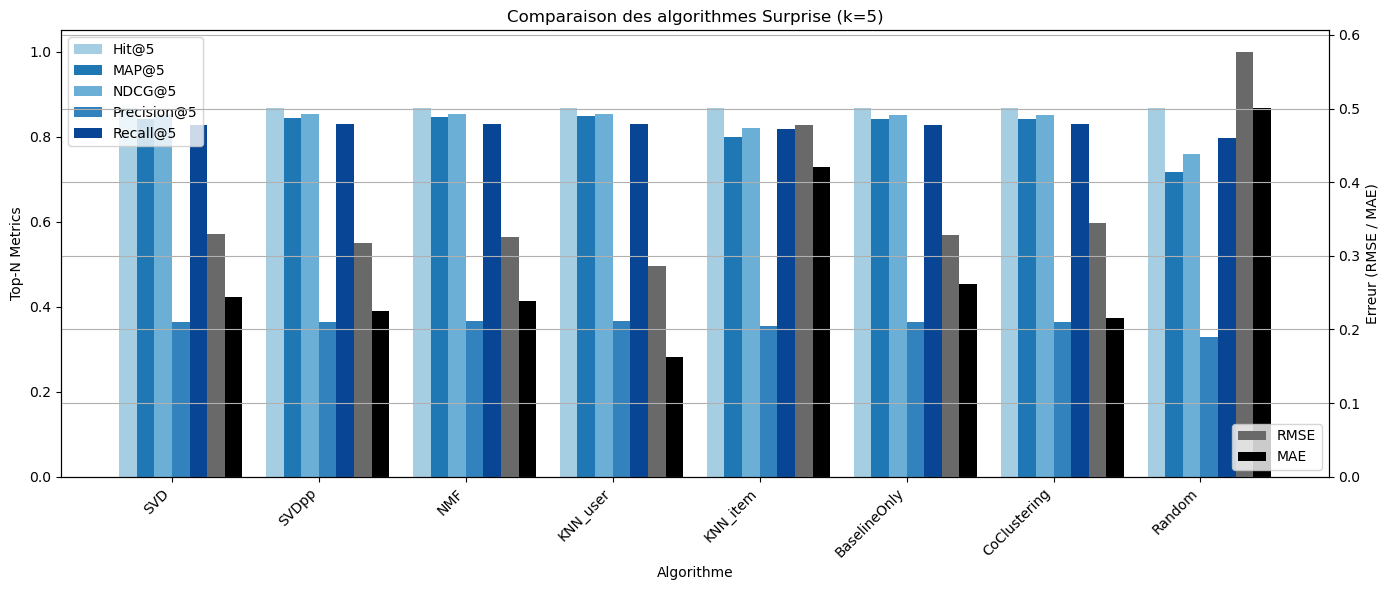

In [21]:
plot_algo_comparison(results_medium)

## Optimisation du meilleur algorithme

In [22]:
# 1. Créer un subset
df_test = create_subset(df, n_users=1000, n_articles=3000, n_interactions=100_000)

# 2. Sampling négatif
df_negatif_embedding = build_negative_sampling_df(df_test, embeddings_df, k=10)

# 3. 🧠 Nouveau filtrage minimal : ne supprimer que les user/items sans AUCUNE interaction
user_counts = df_negatif_embedding['user_id'].value_counts()
item_counts = df_negatif_embedding['article_id'].value_counts()

df_clean = df_negatif_embedding[
    df_negatif_embedding['user_id'].isin(user_counts[user_counts >= 2].index) &
    df_negatif_embedding['article_id'].isin(item_counts[item_counts >= 2].index)
]

[INFO] Shape après filtrage : (8403, 66)
[INFO] Utilisateurs: 1000 | Articles: 2277 | Interactions: 8403
🔍 Génération du sampling négatif avec embeddings (par utilisateur)...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
print(df_clean['rating'].value_counts())

rating
0    72323
1     7138
Name: count, dtype: int64


In [25]:
def print_dataset_reduction(df_original, df_cleaned, label="dataset"):
    n_users_before = df_original['user_id'].nunique()
    n_items_before = df_original['article_id'].nunique()
    n_inter_before = len(df_original)

    n_users_after = df_cleaned['user_id'].nunique()
    n_items_after = df_cleaned['article_id'].nunique()
    n_inter_after = len(df_cleaned)

    print(f"📊 Réduction sur {label} :")
    print(f" - Utilisateurs : {n_users_before} → {n_users_after} ({100 * n_users_after / n_users_before:.1f}%)")
    print(f" - Articles     : {n_items_before} → {n_items_after} ({100 * n_items_after / n_items_before:.1f}%)")
    print(f" - Interactions : {n_inter_before:,} → {n_inter_after:,} ({100 * n_inter_after / n_inter_before:.1f}%)")

# Utilisation :
print_dataset_reduction(df_negatif_embedding, df_clean, label="sampling négatif (embedding)")


📊 Réduction sur sampling négatif (embedding) :
 - Utilisateurs : 1000 → 998 (99.8%)
 - Articles     : 21081 → 9410 (44.6%)
 - Interactions : 91,132 → 79,461 (87.2%)


### Optimisation de SVDpp

In [27]:
from surprise import SVDpp, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
import pandas as pd
import os

# 🔹 1. Chargement des données
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df_clean[['user_id', 'article_id', 'rating']], reader)

# 🔹 2. Définition du param_grid
param_grid = {
    'n_factors': [50, 100, 150],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

# 🔹 3. Grid Search
gs = GridSearchCV(
    algo_class=SVDpp,
    param_grid=param_grid,
    measures=['rmse', 'mae'],
    cv=3,
    n_jobs=-1,
    joblib_verbose=1
)
gs.fit(data)

print("✅ Best RMSE score:", gs.best_score['rmse'])
print("✅ Best parameters:", gs.best_params['rmse'])

# 🔹 4. Reconstruction du trainset complet
trainset = data.build_full_trainset()

# 🔹 5. Meilleur modèle
best_algo = gs.best_estimator['rmse']
best_params = gs.best_params['rmse']
best_algo.fit(trainset)

# 🔧 Affichage des hyperparamètres
print("🔧 Paramètres du meilleur modèle SVDpp :")
for param, val in best_params.items():
    print(f" - {param:<10}: {val}")

# 🔹 6. Évaluation complète
testset = trainset.build_testset()
predictions = best_algo.test(testset)

rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)
top_n = get_top_n(predictions, n=5)
topn_metrics = eval_top_n(top_n, testset, k=5)

# 🔸 Résumé
print("\n🎯 Résultats finaux sur le meilleur modèle SVDpp (top-5) :")
print(f"RMSE       : {rmse:.4f}")
print(f"MAE        : {mae:.4f}")
for k, v in topn_metrics.items():
    print(f"{k:<12}: {v:.4f}")

# 🔹 7. Enregistrement dans le CSV
chemin_resultats = "./results/eval_results.csv"
n_users = df_clean['user_id'].nunique()
n_articles = df_clean['article_id'].nunique()
n_interactions = len(df_clean)

result = {
    "modèle": "SVDpp (gridsearch)",
    "approche": "Surprise (Collaborative Filtering)",
    "n_users": n_users,
    "n_articles": n_articles,
    "n_interactions": n_interactions,
    "RMSE": rmse,
    "MAE": mae,
    "Hit@5": topn_metrics["HitRate@5"],
    "MAP@5": topn_metrics["MAP@5"],
    "NDCG@5": topn_metrics["NDCG@5"],
    "Precision@5": topn_metrics["Precision@5"],
    "Recall@5": topn_metrics["Recall@5"]
}

colonnes_ordre = [
    "modèle", "approche", "n_users", "n_articles", "n_interactions",
    "RMSE", "MAE", "Hit@5", "MAP@5", "NDCG@5", "Precision@5", "Recall@5"
]

os.makedirs(os.path.dirname(chemin_resultats), exist_ok=True)
if os.path.exists(chemin_resultats):
    df_old = pd.read_csv(chemin_resultats)
    df_all = pd.concat([df_old, pd.DataFrame([result])], ignore_index=True)
else:
    df_all = pd.DataFrame([result])

df_all = df_all[colonnes_ordre]
df_all.to_csv(chemin_resultats, index=False)

# 🔹 8. Résultats du grid search
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df = results_df.sort_values(by='mean_test_rmse')
display(results_df[['params', 'mean_test_rmse', 'mean_test_mae']])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.5min finished


✅ Best RMSE score: 0.18859630499434746
✅ Best parameters: {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.1}
🔧 Paramètres du meilleur modèle SVDpp :
 - n_factors : 50
 - lr_all    : 0.005
 - reg_all   : 0.1

🎯 Résultats finaux sur le meilleur modèle SVDpp (top-5) :
RMSE       : 0.1557
MAE        : 0.0628
HitRate@5   : 0.9780
MAP@5       : 0.9273
NDCG@5      : 0.9451
Precision@5 : 0.6737
Recall@5    : 0.7645


,params,mean_test_rmse,mean_test_mae
3,"{'n_factors': 50, 'lr_all': 0.005, 'reg_all': ...",0.188596,0.093148
2,"{'n_factors': 50, 'lr_all': 0.005, 'reg_all': ...",0.191558,0.096504
7,"{'n_factors': 100, 'lr_all': 0.005, 'reg_all':...",0.191792,0.096381
11,"{'n_factors': 150, 'lr_all': 0.005, 'reg_all':...",0.194178,0.099097
6,"{'n_factors': 100, 'lr_all': 0.005, 'reg_all':...",0.198869,0.104297
10,"{'n_factors': 150, 'lr_all': 0.005, 'reg_all':...",0.204581,0.110263
1,"{'n_factors': 50, 'lr_all': 0.002, 'reg_all': ...",0.221051,0.118844
0,"{'n_factors': 50, 'lr_all': 0.002, 'reg_all': ...",0.223722,0.122144
5,"{'n_factors': 100, 'lr_all': 0.002, 'reg_all':...",0.225213,0.122921
9,"{'n_factors': 150, 'lr_all': 0.002, 'reg_all':...",0.228794,0.126452


### Optimisation de KNN user

🔍 On va optimiser par GridSearch sur KNN_user avec Surprise

On va faire varier :

- k : nombre de voisins (taille du voisinage)
- min_k : minimum de voisins requis pour prédire
- similarity : type de similarité <br>
Il faut filter la matrice des embeddings négatifs pour exclure les users avec un rating de 0 (erreur de div 0 pour cosine et pearson), mais pas depuis la matrice sparse

In [21]:
from surprise import KNNBasic
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader

# Grille de paramètres
param_grid = {
    'k': [20, 40, 60],
    'min_k': [1, 3, 5],
    'sim_options__name': ['cosine', 'msd', 'pearson'],
    'sim_options__user_based': [True]  # ou False pour item-based
}

In [22]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(df_clean[['user_id', 'article_id', 'rating']], reader)

In [23]:
gs = GridSearchCV(
    algo_class=KNNBasic,
    param_grid=param_grid,
    measures=['rmse', 'mae'],
    cv=3,
    n_jobs=-1,
    joblib_verbose=1
)
gs.fit(data)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    5.8s finished


🏆 Meilleurs paramètres

In [24]:
print("Best RMSE score:", gs.best_score['rmse'])
print("Best parameters:", gs.best_params['rmse'])

Best RMSE score: 0.13000629162783015
Best parameters: {'k': 20, 'min_k': 1, 'sim_options__name': 'cosine', 'sim_options__user_based': True}


📊 Classement des meilleurs modèles

In [25]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df = results_df.sort_values(by='mean_test_rmse')
display(results_df[['params', 'mean_test_rmse', 'mean_test_mae']])

,params,mean_test_rmse,mean_test_mae
0,"{'k': 20, 'min_k': 1, 'sim_options__name': 'co...",0.130006,0.029731
1,"{'k': 20, 'min_k': 1, 'sim_options__name': 'ms...",0.130006,0.029731
2,"{'k': 20, 'min_k': 1, 'sim_options__name': 'pe...",0.130006,0.029731
9,"{'k': 40, 'min_k': 1, 'sim_options__name': 'co...",0.130429,0.030225
10,"{'k': 40, 'min_k': 1, 'sim_options__name': 'ms...",0.130429,0.030225
11,"{'k': 40, 'min_k': 1, 'sim_options__name': 'pe...",0.130429,0.030225
20,"{'k': 60, 'min_k': 1, 'sim_options__name': 'pe...",0.130890,0.030567
19,"{'k': 60, 'min_k': 1, 'sim_options__name': 'ms...",0.130890,0.030567
18,"{'k': 60, 'min_k': 1, 'sim_options__name': 'co...",0.130890,0.030567
3,"{'k': 20, 'min_k': 3, 'sim_options__name': 'co...",0.160931,0.050976


In [54]:
# ⚙️ Reconstruction du trainset complet
trainset = data.build_full_trainset()

# 🏆 Extraction du meilleur algo trouvé par GridSearch
best_algo = gs.best_estimator['rmse']
best_params = gs.best_params['rmse']
best_algo.fit(trainset)

# 🔍 Affichage clair des hyperparamètres
print("🔧 Paramètres du meilleur modèle :")
print(f" - k              : {best_params['k']}")
print(f" - min_k          : {best_params['min_k']}")
print(f" - similarité     : {best_params['sim_options__name']}")
print(f" - user_based     : {best_params['sim_options__user_based']}")

# 📌 Générer le testset manuellement (tous les ratings connus)
testset = trainset.build_testset()
predictions = best_algo.test(testset)

# 🔢 Métriques de prédiction
from surprise import accuracy
rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)

# 🔝 Métriques de recommandation top-N
top_n = get_top_n(predictions, n=5)
topn_metrics = eval_top_n(top_n, testset, k=5)

# 🧾 Résumé
print("\n🎯 Résultats finaux sur le meilleur modèle (top-5) :")
print(f"RMSE       : {rmse:.4f}")
print(f"MAE        : {mae:.4f}")
for k, v in topn_metrics.items():
    print(f"{k:<12}: {v:.4f}")


Computing the msd similarity matrix...
Done computing similarity matrix.
🔧 Paramètres du meilleur modèle :
 - k              : 20
 - min_k          : 1
 - similarité     : cosine
 - user_based     : True

🎯 Résultats finaux sur le meilleur modèle (top-5) :
RMSE       : 0.0825
MAE        : 0.0141
HitRate@5   : 0.9780
MAP@5       : 0.9677
NDCG@5      : 0.9716
Precision@5 : 0.6948


Bien qu'intéressant les contraintes d'utilisation de knn sont trop importantes, en plus cet algorithme n'est pas fait pour prédire des scores continus.

### Visualisation

In [31]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random
import math
from matplotlib.lines import Line2D

def show_topn_visual(top_n, df_truth, embedding_dict, df_metadata=None, n_users=6):
    sampled_users = random.sample(list(top_n.keys()), n_users)
    valid_results = []

    for uid in sampled_users:
        real_clicks = df_truth[(df_truth['user_id'] == uid) & (df_truth['rating'] > 0)]['article_id'].unique()
        recs = top_n[uid]

        vectors, labels, markers, colors, outlines, article_ids = [], [], [], [], [], []

        for aid in real_clicks:
            if aid in embedding_dict:
                vectors.append(embedding_dict[aid])
                labels.append("Clicked")
                colors.append("blue")
                markers.append("o")
                outlines.append(False)
                article_ids.append(aid)

        for aid, score in recs:
            if aid in embedding_dict:
                vectors.append(embedding_dict[aid])
                is_clicked = aid in real_clicks
                article_ids.append(aid)
                markers.append("s")
                outlines.append(score >= 0.9)

                if is_clicked:
                    labels.append("Recommended & Clicked")
                    colors.append("red")
                else:
                    labels.append("Recommended")
                    colors.append("green")

        if len(vectors) >= 2:
            X = np.array(vectors)
            perplexity = max(2, min(30, len(X) - 1))
            tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
            proj = tsne.fit_transform(X)
            valid_results.append((uid, proj, labels, colors, markers, outlines, article_ids))
        else:
            print(f"[⚠️] Utilisateur {uid} ignoré (pas assez d’articles avec embeddings).")

    if not valid_results:
        print("Aucun utilisateur avec données valides pour visualisation.")
        return

    total = len(valid_results)
    rows = math.ceil(total / 2)
    fig, axes = plt.subplots(rows, 2, figsize=(18, 5 * rows))
    if rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    legend_entries = {}

    for idx, (uid, proj, labels, colors, markers, outlines, article_ids) in enumerate(valid_results):
        ax = axes[idx]
        for i, label in enumerate(labels):
            key = (label, colors[i], markers[i])
            if key not in legend_entries:
                legend_entries[key] = (colors[i], markers[i])

            ax.scatter(proj[i, 0], proj[i, 1],
                       c=colors[i],
                       marker=markers[i],
                       s=100,
                       label=None,
                       edgecolors='black' if outlines[i] else 'none',
                       linewidths=2 if outlines[i] else 1)
            ax.annotate(article_ids[i], (proj[i, 0]+1, proj[i, 1]+1), fontsize=8)

        ax.set_title(f"Utilisateur {uid}")
        ax.grid(True)

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    # Légende globale complète
    legend_handles = [
        Line2D([0], [0], marker=marker, color=color, linestyle='',
               label=label, markersize=10,
               markeredgecolor='black' if label.startswith("Recommended") else 'none',
               markeredgewidth=2 if label.startswith("Recommended") else 1)
        for (label, color, marker) in legend_entries
    ]
    fig.legend(handles=legend_handles, loc='upper center', ncol=4, fontsize=10)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Visualisation t-SNE des recommandations et clics", fontsize=16)
    plt.show()


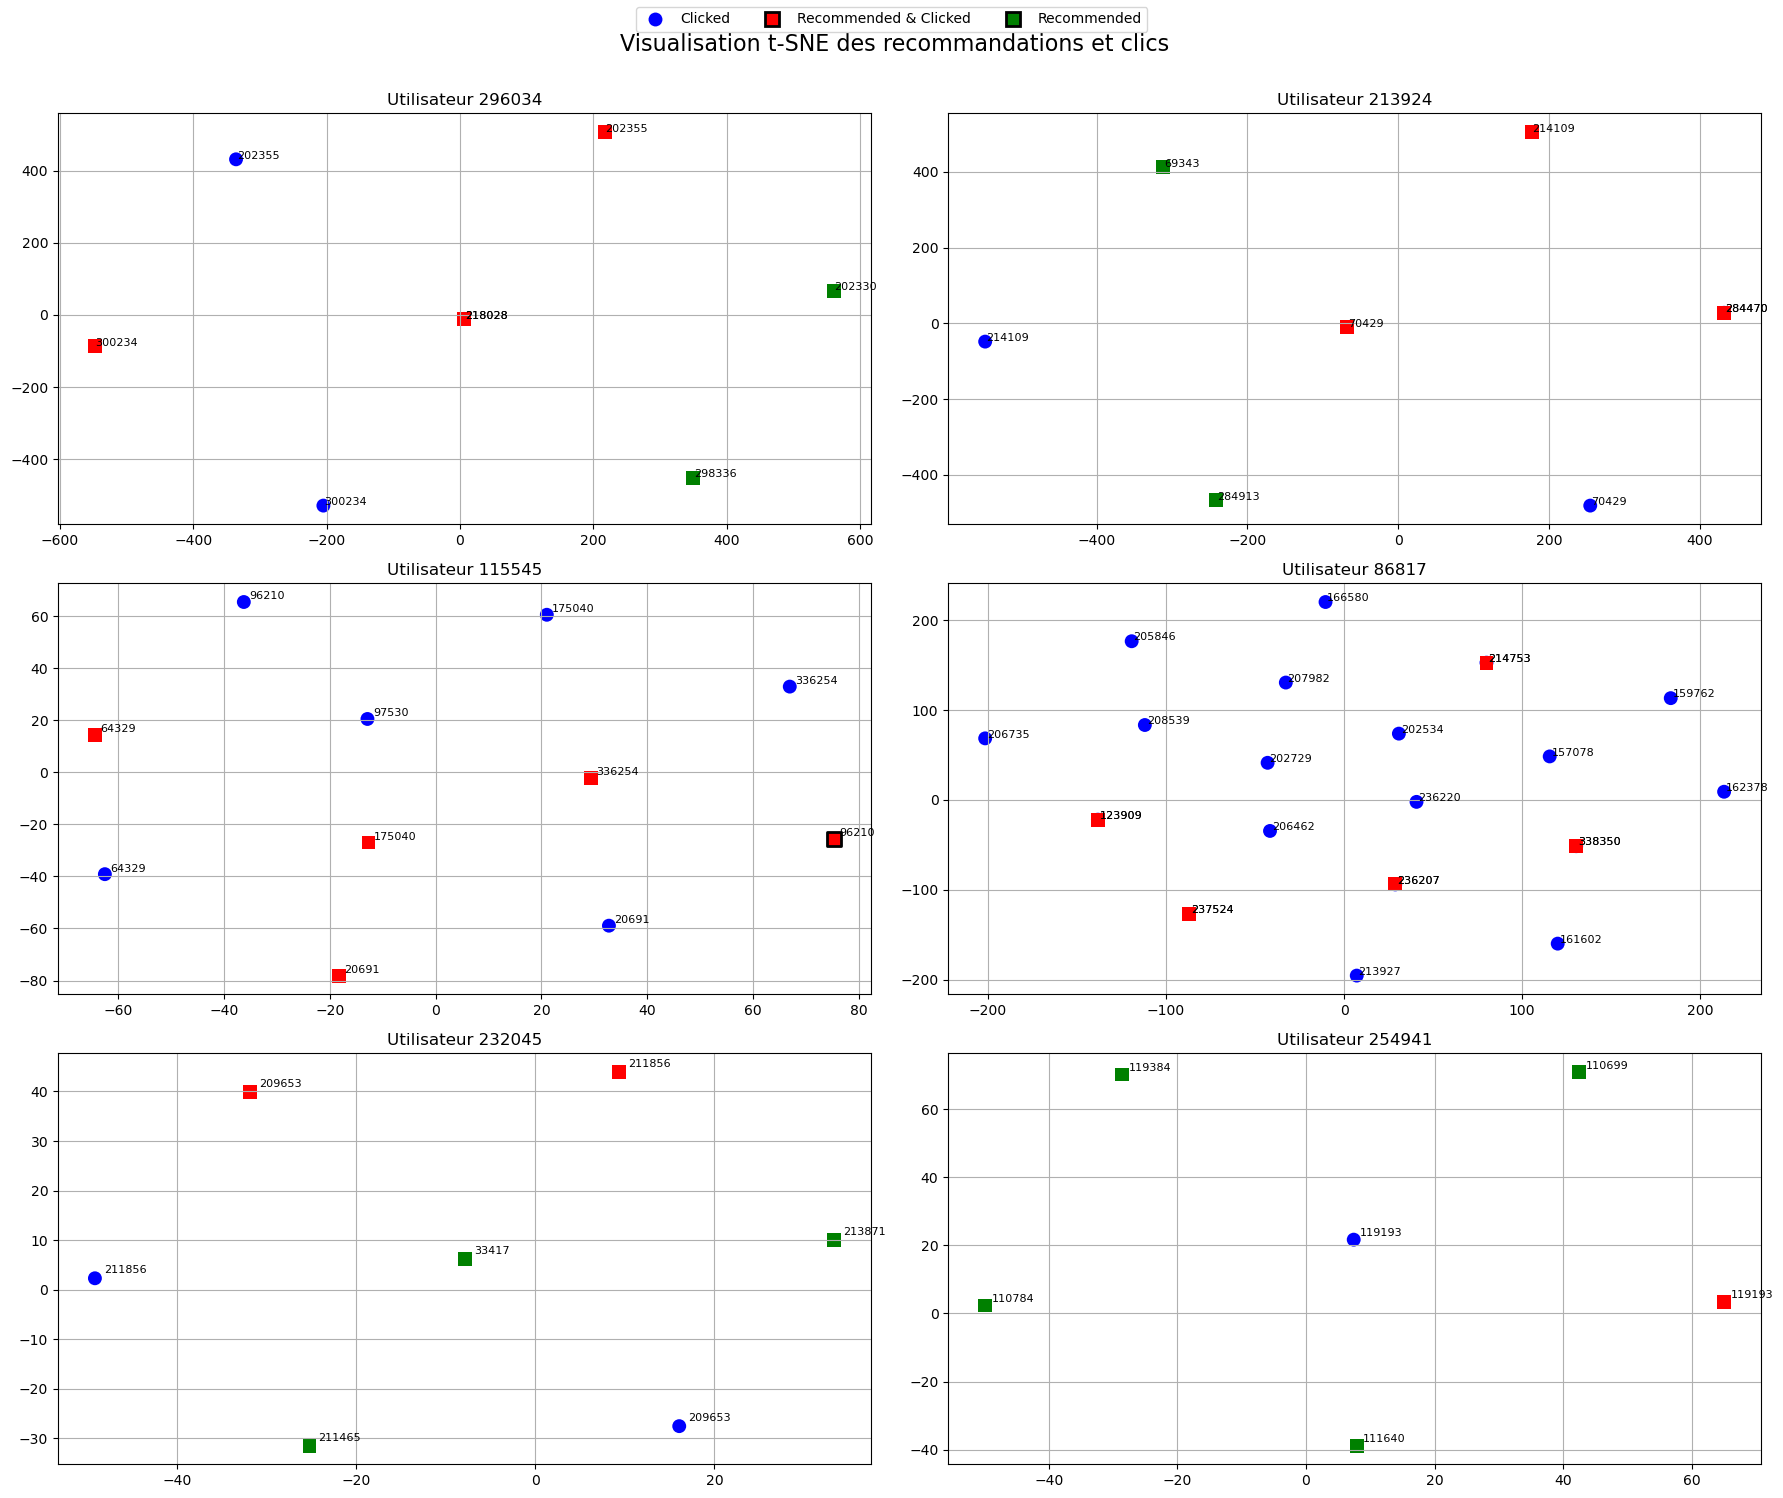

In [34]:
show_topn_visual(top_n, df_clean, embedding_dict, n_users=6)

## Conclusion

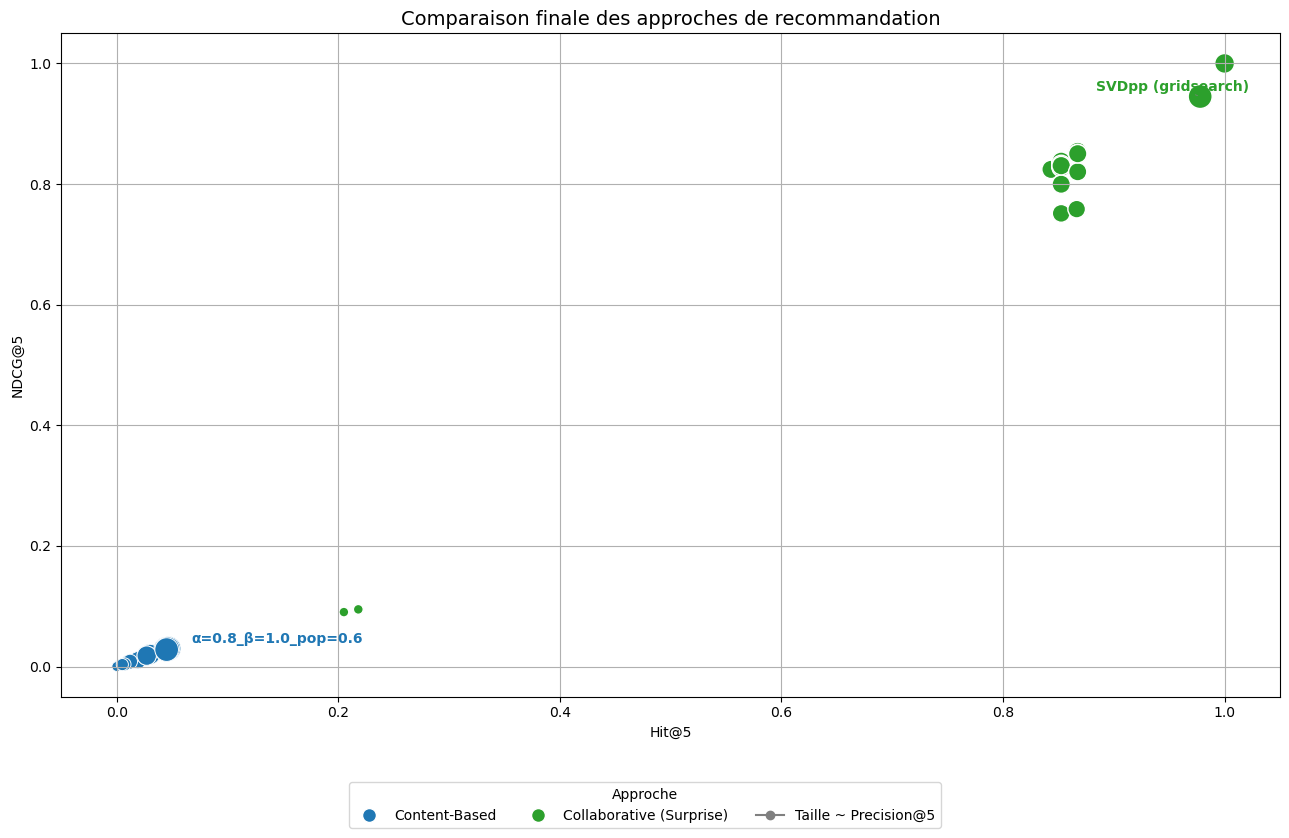

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.lines import Line2D

# 🔹 1. Chargement et calcul du score
df = pd.read_csv("./results/eval_results.csv")

df["score_composite"] = (
    0.4 * df["Hit@5"] +
    0.4 * df["NDCG@5"] +
    0.2 * df["Precision@5"]
)

# 🔹 2. Détection des meilleures approches
df_cb = df[df["approche"].str.contains("Content", case=False, na=False)].copy()
df_cf = df[df["approche"].str.contains("Surprise", case=False, na=False)].copy()

best_cb = df_cb.loc[df_cb["score_composite"].idxmax()]
best_cf = df_cf.loc[df_cf["score_composite"].idxmax()]

# 🔹 3. Création du graphique
fig, ax = plt.subplots(figsize=(13, 8))

# Ajout avec couleurs par approche
sns.scatterplot(
    data=df_cb, x="Hit@5", y="NDCG@5",
    hue=["Content-Based"] * len(df_cb),
    size="Precision@5",
    palette=["#1f77b4"], sizes=(50, 300), ax=ax, legend=False
)

sns.scatterplot(
    data=df_cf, x="Hit@5", y="NDCG@5",
    hue=["Surprise"] * len(df_cf),
    size="Precision@5",
    palette=["#2ca02c"], sizes=(50, 300), ax=ax, legend=False
)

# 🔹 4. Ajout des deux meilleurs modèles
texts = []
texts.append(ax.text(best_cb["Hit@5"], best_cb["NDCG@5"],
                     best_cb["modèle"], fontsize=10, fontweight="bold", color="#1f77b4"))
texts.append(ax.text(best_cf["Hit@5"], best_cf["NDCG@5"],
                     best_cf["modèle"], fontsize=10, fontweight="bold", color="#2ca02c"))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# 🔹 5. Axes, titres, légendes
ax.set_title("Comparaison finale des approches de recommandation", fontsize=14)
ax.set_xlabel("Hit@5")
ax.set_ylabel("NDCG@5")
ax.grid(True)

# Légende manuelle
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Content-Based',
           markerfacecolor='#1f77b4', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Collaborative (Surprise)',
           markerfacecolor='#2ca02c', markersize=10),
    Line2D([0], [0], marker='o', color='gray', label='Taille ~ Precision@5',
           markerfacecolor='gray', markersize=6)
]

fig.legend(handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.05),
           ncol=3, title="Approche")

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


📊 Analyse du graphique
✅ Les modèles collaboratifs (verts) sont regroupés très haut à droite → excellents scores en Hit@5, NDCG@5, Precision@5. Le SVDpp optimisé est encore légèrement au-dessus des autres. Ils tirent parti des interactions entre utilisateurs : plus riches en information si bien préparées.

🟦 Les modèles content-based (bleus). Très regroupés en bas à gauche, ce qui reflète une capacité de personnalisation limitée :<br>
- Ils ne font aucune généralisation inter-utilisateur.
- Leur performance dépend surtout de la qualité des features d’articles (embeddings, similarité).

| Aspect                     | Content-Based                                   | Collaborative Filtering (Surprise)           |
| -------------------------- | ----------------------------------------------- | -------------------------------------------- |
| **Source de signal**       | Similarité d’articles (métadonnées, embeddings) | Historique d’interactions                    |
| **Modèle entraîné ?**      | Pas toujours (peut être purement basé règles)   | Oui (modèles probabilistes ou factorisation) |
| **Cold Start utilisateur** | ❌ Faible personnalisation possible              | ✅ Meilleure si historique d’interactions     |
| **Cold Start item**        | ✅ Possible via features                         | ❌ Difficile sans interactions                |
| **Complexité**             | Simple à déployer                               | Plus lourd (entraînement, tuning)            |
| **Personnalisation fine**  | Limitée                                         | Forte                                        |


📌 Ce que l'on peut conclure: Les approches collaboratives surperforment largement sur les métriques top-N, cela signifie qu’en présence d’un historique utilisateur riche et d’un bon sampling, elles sont à privilégier.<br>
Les content-based sont très en retrait mais ont un rôle crucial de repli quand un utilisateur est nouveau (cold start), elles sont les seules disponibles. Elles peuvent enrichir les modèles hybrides.